In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/ParisFireBrigade/'

Mounted at /content/drive


# Paris Fire Brigade Challenge

In [0]:
# imports
import numpy as np
import pandas as pd
from pprint import pprint
import json
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy.stats import pearsonr

# Scrapping

In [0]:
# scrap meteorological data

# put True to get meteo_2018.json
scrap_data = False

if scrap_data:
    import re
    from selenium import webdriver
    from bs4 import BeautifulSoup

    # download a driver on the Internet
    driver = webdriver.Chrome('C:/Program Files (x86)/Google/Chrome/Application/chromedriver.exe')

    # keys: feature names on the website
    # values: feature names to be in the in the dataframe
    names_mapping = {'Température maximale': 'max_temp',
                     'Température minimale': 'min_temp',
                     'Vitesse du vent': 'wind_speed',
                     'Température du vent': 'wind_temp',
                     'Précipitations': 'rain_level',
                     'Humidité': 'humidity',
                     'Visibilité': 'visibility',
                     'Couverture nuageuse': 'cloud_coverage',
                     'Indice de chaleur': 'heat_index',
                     'Point de rosée': 'dew_point_temp',
                     'Pression': 'pressure',
                     'Heure du lever du soleil': 'sunrise',
                     'Heure du coucher du soleil': 'sunset',
                     'Durée du jour': 'length_day',
                     'L\'avis de historique-meteo.net': 'review'
                    }
    
    # to store the features of each day in the loop
    tmp_meteo_dict = {'Température maximale': None,
                      'Température minimale': None,
                      'Vitesse du vent': None,
                      'Température du vent': None,
                      'Précipitations': None,
                      'Humidité': None,
                      'Visibilité': None,
                      'Couverture nuageuse': None,
                      'Indice de chaleur': None,
                      'Point de rosée': None,
                      'Pression': None,
                      'Heure du lever du soleil': None,
                      'Heure du coucher du soleil': None,
                      'Durée du jour': None,
                      'L\'avis de historique-meteo.net': None
                     }
    
    # to store everything
    meteo_features = dict()
    
    
    for k in range(1, 13):  # month
        meteo_features[k] = dict()
        for l in range(1, 32):  # day
            meteo_features[k][l] = None

            # format month and day
            month = '0' + str(k) if k <= 9 else str(k)
            day = str(l) if l >= 10 else '0' + str(l)
            
            # get the associated webpage
            driver.get('https://www.historique-meteo.net/france/ile-de-france/paris/2018/{}/{}/'.format(month, day))
            content = driver.page_source
            soup = BeautifulSoup(content)

            # if the day is in the calendar
            if 'Erreur 404' not in soup.find('title').text:
                # features to retrieve
                f_names = list(names_mapping.keys())

                # for each row of the table
                for tr in soup.findAll('tr'):
                    feature_name = tr.find('td').text
                    if len(feature_name) != 0:  # if this is a feature
                        feature_data = tr.find('td', attrs={'class': ['text-center bg-primary', 'bg-primary text-center']}).text
                        
                        # keep only the data
                        filtered = re.findall(r'-?\d+\.?\d*', feature_data)  # keep numerical data
                        len_filtered = len(filtered)
                        if len_filtered == 0:  # nothing changes if it is the review
                            filtered = feature_data
                        elif len_filtered == 1:  # convert if float
                            filtered = float(filtered[0])
                        else:  # join if time
                            filtered = ':'.join(filtered)

                        # store the feature
                        tmp_meteo_dict[feature_name] = filtered

                        # remove the feature from the to-retrieve list
                        f_names.remove(feature_name)

                # for the features that were not displayed
                for feature_name in f_names:
                    tmp_meteo_dict[feature_name] = 0

                # store the result
                meteo_features[k][l] = dict(zip(list(names_mapping.values()), list(tmp_meteo_dict.values())))

    # save meteorological data
    with open(path + 'meteo_2018.json', 'w') as fp:
        json.dump(meteo_features, fp)

else:
    with open(path + 'meteo_2018.json', 'r') as f:
        meteo_features = json.load(f)

# Dataset

In [0]:
# data reading
x_train = pd.read_csv(path + 'x_train.csv', sep=',')
x_train_add = pd.read_csv(path + 'x_train_additional_file.csv', sep=',')
y_train = pd.read_csv(path + 'y_train.csv', sep=',')

x_test = pd.read_csv(path + 'x_test.csv', sep=',')
x_test_add = pd.read_csv(path + 'x_test_additional_file.csv', sep=',')

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
x_train.head()

emergency vehicle selection  ...  OSRM estimated duration
0                      5105452  ...                  105.800
1                      4720915  ...                  243.200
2                      5365374  ...                  295.400
3                      4741586  ...                  166.600
4                      5381209  ...                  262.600

[5 rows x 26 columns]

In [6]:
x_train_add.head()

emergency vehicle selection  ... updated OSRM estimated duration
0                      5105452  ...                         482.810
1                      4720915  ...                             nan
2                      5365374  ...                         557.323
3                      4741586  ...                         318.880
4                      5381209  ...                         719.983

[5 rows x 6 columns]

In [7]:
y_train.drop(['emergency vehicle selection'], axis=1).describe()

delta selection-departure  ...  delta selection-presentation
count                 219337.000  ...                    219337.000
mean                     138.772  ...                       494.933
std                       77.711  ...                       243.195
min                        0.000  ...                         4.000
25%                      100.000  ...                       363.000
50%                      131.000  ...                       458.000
75%                      168.000  ...                       581.000
max                    17758.000  ...                     22934.000

[8 rows x 3 columns]

In [8]:
# copy the dataset
train = x_train.copy()
test = x_test.copy()

# add labels to dataframe
train['delta selection-departure'] = y_train['delta selection-departure']
train['delta departure-presentation'] = y_train['delta departure-presentation']
train['delta selection-presentation'] = y_train['delta selection-presentation']

train['log selection-departure'] = np.log(train['delta selection-departure'])
train['log departure-presentation'] = np.log(train['delta departure-presentation'])

# update estimated OSRM duration
not_updated = x_train_add['updated OSRM estimated duration'].isna()  # 1 if nan, 0 otherwise
train['updated OSRM duration'] = not_updated * train['OSRM estimated duration'] + np.nan_to_num(x_train_add['updated OSRM estimated duration'])
train.loc[train['updated OSRM duration'] >= 4000, 'updated OSRM duration'] -= 2000
train['updated OSRM'] = ~not_updated

not_updated = x_test_add['updated OSRM estimated duration'].isna()  # 1 if nan, 0 otherwise
test['updated OSRM duration'] = not_updated * test['OSRM estimated duration'] + np.nan_to_num(x_test_add['updated OSRM estimated duration'])
test.loc[test['updated OSRM duration'] >= 4000, 'updated OSRM duration'] -= 2000
test['updated OSRM'] = ~not_updated

# use GPS to estimate duration
gps_isna = x_train['GPS tracks datetime departure-presentation'].isna() # 1 if nan, 0 otherwise
start_dates = pd.to_datetime(list(map(lambda x: x[0], train[~gps_isna]['GPS tracks datetime departure-presentation'].str.split(';'))))
end_dates = pd.to_datetime(list(map(lambda x: x[-1], train[~gps_isna]['GPS tracks datetime departure-presentation'].str.split(';'))))
deltas = (end_dates - start_dates).seconds

train['GPS estimation'] = np.zeros(len(train))
train.loc[~gps_isna, 'GPS estimation'] = deltas
train.loc[gps_isna, 'GPS estimation'] = train.loc[gps_isna, 'OSRM estimated duration']
train['GPS available'] = ~gps_isna

gps_isna = x_test['GPS tracks datetime departure-presentation'].isna() # 1 if nan, 0 otherwise
start_dates = pd.to_datetime(list(map(lambda x: x[0], test[~gps_isna]['GPS tracks datetime departure-presentation'].str.split(';'))))
end_dates = pd.to_datetime(list(map(lambda x: x[-1], test[~gps_isna]['GPS tracks datetime departure-presentation'].str.split(';'))))
deltas = (end_dates - start_dates).seconds

test['GPS estimation'] = np.zeros(len(test))
test.loc[~gps_isna, 'GPS estimation'] = deltas
test.loc[gps_isna, 'GPS estimation'] = test.loc[gps_isna, 'OSRM estimated duration']
test['GPS available'] = ~gps_isna

# combine updated OSRM and GPS
train['GPS and updated OSRM'] = .5 * (train['updated OSRM duration'] + train['GPS estimation'])
test['GPS and updated OSRM'] = .5 * (test['updated OSRM duration'] + test['GPS estimation'])

# remove outliers for selection-departure
m = y_train['delta selection-departure'].mean()
s = y_train['delta selection-departure'].std()

train = train[train['delta selection-departure'] <= m + 5*s]
train = train[train['delta selection-departure'] >= m - 5*s]
train = train[train['delta selection-departure'] >= 3]

# remove outliers for departure-presentation
m = y_train['delta departure-presentation'].mean()
s = y_train['delta departure-presentation'].std()

train = train[train['delta departure-presentation'] <= m + 4*s]
train = train[train['delta departure-presentation'] >= m - 4*s]
train = train[train['delta departure-presentation'] >= 10]

train[['delta selection-departure', 'delta departure-presentation', 'delta selection-presentation']].describe()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


delta selection-departure  ...  delta selection-presentation
count                 218022.000  ...                    218022.000
mean                     138.013  ...                       486.855
std                       55.545  ...                       178.881
min                        3.000  ...                        23.000
25%                      100.000  ...                       362.000
50%                      131.000  ...                       458.000
75%                      168.000  ...                       578.000
max                      527.000  ...                      1738.000

[8 rows x 3 columns]

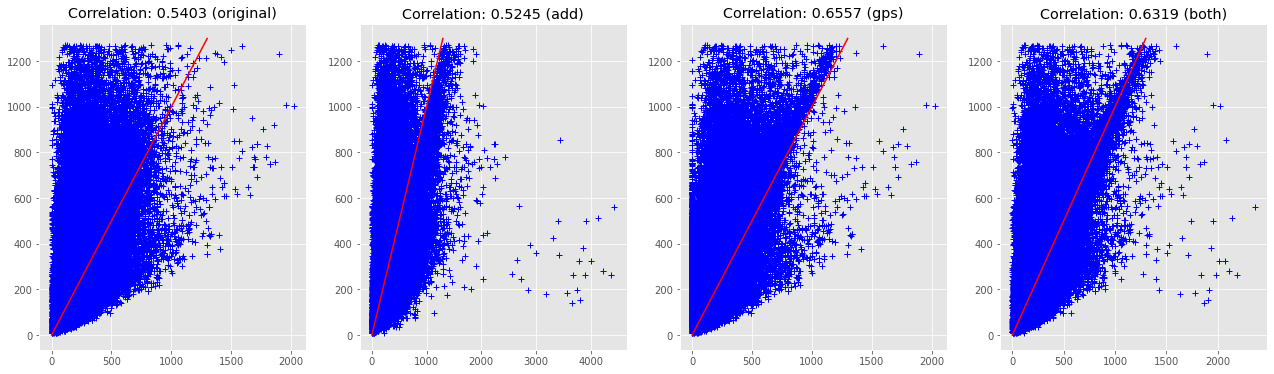

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


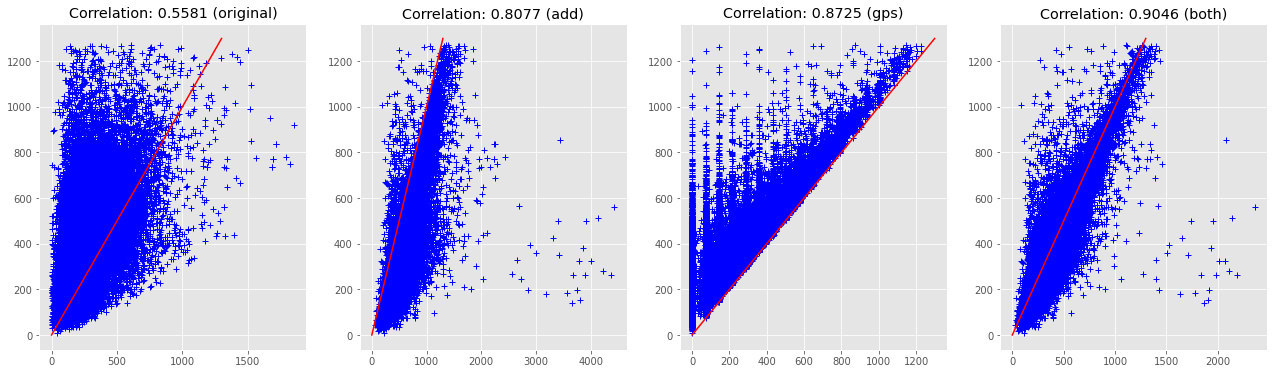

In [9]:
plt.figure(figsize=(22, 6))
plt.subplot(141)
corr = pearsonr(train['OSRM estimated duration'], train['delta departure-presentation'])[0]
plt.title('Correlation: {} (original)'.format(np.round(corr, 4)))
plt.plot(train['OSRM estimated duration'], train['delta departure-presentation'], 'b+')
plt.plot(np.arange(0, 1300), np.arange(0, 1300), 'r')

plt.subplot(142)
corr = pearsonr(train['updated OSRM duration'], train['delta departure-presentation'])[0]
plt.title('Correlation: {} (add)'.format(np.round(corr, 4)))
plt.plot(train['updated OSRM duration'], train['delta departure-presentation'], 'b+')
plt.plot(np.arange(0, 1300), np.arange(0, 1300), 'r')

plt.subplot(143)
corr = pearsonr(train['GPS estimation'], train['delta departure-presentation'])[0]
plt.title('Correlation: {} (gps)'.format(np.round(corr, 4)))
plt.plot(train['GPS estimation'], train['delta departure-presentation'], 'b+')
plt.plot(np.arange(0, 1300), np.arange(0, 1300), 'r')

plt.subplot(144)
corr = pearsonr(.5 * (train['updated OSRM duration'] + train['GPS estimation']), train['delta departure-presentation'])[0]
plt.title('Correlation: {} (both)'.format(np.round(corr, 4)))
plt.plot(.5 * (train['updated OSRM duration'] + train['GPS estimation']), train['delta departure-presentation'], 'b+')
plt.plot(np.arange(0, 1300), np.arange(0, 1300), 'r')
plt.show()

# consider only the updated points
condition = train['updated OSRM'] * train['GPS available']

plt.figure(figsize=(22, 6))
plt.subplot(141)
corr = pearsonr(train[condition]['OSRM estimated duration'], train[condition]['delta departure-presentation'])[0]
plt.title('Correlation: {} (original)'.format(np.round(corr, 4)))
plt.plot(train[condition]['OSRM estimated duration'], train[condition]['delta departure-presentation'], 'b+')
plt.plot(np.arange(0, 1300), np.arange(0, 1300), 'r')

plt.subplot(142)
corr = pearsonr(train[condition]['updated OSRM duration'], train[condition]['delta departure-presentation'])[0]
plt.title('Correlation: {} (add)'.format(np.round(corr, 4)))
plt.plot(train[condition]['updated OSRM duration'], train[condition]['delta departure-presentation'], 'b+')
plt.plot(np.arange(0, 1300), np.arange(0, 1300), 'r')

plt.subplot(143)
corr = pearsonr(train[condition]['GPS estimation'], train[condition]['delta departure-presentation'])[0]
plt.title('Correlation: {} (gps)'.format(np.round(corr, 4)))
plt.plot(train[condition]['GPS estimation'], train[condition]['delta departure-presentation'], 'b+')
plt.plot(np.arange(0, 1300), np.arange(0, 1300), 'r')

plt.subplot(144)
corr = pearsonr(.5 * (train[condition]['updated OSRM duration'] + train[condition]['GPS estimation']), train[condition]['delta departure-presentation'])[0]
plt.title('Correlation: {} (both)'.format(np.round(corr, 4)))
plt.plot(.5 * (train[condition]['updated OSRM duration'] + train[condition]['GPS estimation']), train[condition]['delta departure-presentation'], 'b+')
plt.plot(np.arange(0, 1300), np.arange(0, 1300), 'r')
plt.show()

In [0]:
# month, day, hour features
tmp = pd.to_datetime(train['selection time'])
train['month'] = tmp.dt.month
train['day'] = tmp.dt.day
train['day of week'] = tmp.dt.dayofweek
train['hour'] = tmp.dt.hour

tmp = pd.to_datetime(test['selection time'])
test['month'] = tmp.dt.month
test['day'] = tmp.dt.day
test['day of week'] = tmp.dt.dayofweek
test['hour'] = tmp.dt.hour

In [0]:
# meteorological features
meteo_names = ['max_temp',
               'min_temp',
               'wind_speed',
               'wind_temp',
               'rain_level',
               'humidity',
               'visibility',
               'cloud_coverage',
               'heat_index',
               'dew_point_temp',
               'pressure',
               'sunrise',
               'sunset',
               'length_day',
               'review'
              ]

for meteo_f in meteo_names:
    train[meteo_f] = [meteo_features[str(m)][str(d)][meteo_f]
                      for (m, d) in zip(train['month'].values, train['day'].values)]
    
    test[meteo_f] = [meteo_features[str(m)][str(d)][meteo_f]
                     for (m, d) in zip(test['month'].values, test['day'].values)]

In [0]:
# group some vehicle types
train['emergency vehicle type'] = train['emergency vehicle type'].str.partition(' ')[0]
test['emergency vehicle type'] = test['emergency vehicle type'].str.partition(' ')[0]

In [0]:
# label encoding for data analysis section
train['alert_reason_id'] = train['alert reason'].astype('category').cat.codes
train['vehicle_type_id'] = train['emergency vehicle type'].astype('category').cat.codes
train['rescue_center_id'] = train['rescue center'].astype('category').cat.codes
train['status_preceding_selection_id'] = train['status preceding selection'].astype('category').cat.codes
train['review_id'] = train['review'].astype('category').cat.codes

# Data Analysis

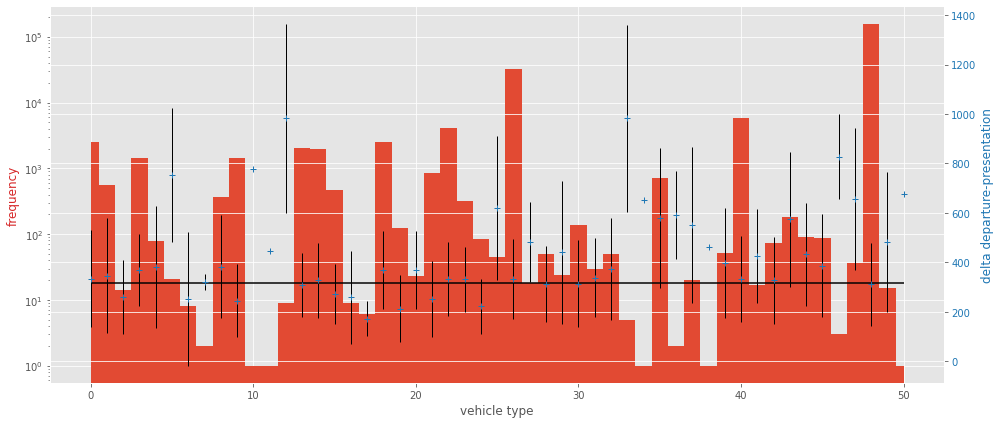

In [14]:
name_vehicle_col = 'vehicle_type_id'
y_label = 'delta departure-presentation'
color = 'tab:red'

fig = plt.figure()
freq, _, _ = plt.hist(train[name_vehicle_col], color=color, alpha=.5, bins=len(set(train[name_vehicle_col])))
plt.close(fig)

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_yscale('log')
ax1.set_xlabel('vehicle type')
ax1.set_ylabel('frequency', color=color)
# ax1.set_xticks(np.arange(len(set(train['vehicle_type_id']))))
ax1.fill_between(x=np.array(list(set(train[name_vehicle_col]))), y1=0, y2=freq, step='mid')
# ax1.vlines(.5+np.array(list(set(train['vehicle_type_id']))), ymin=0, ymax=2e5, color='white')
# ax1.hist(train['vehicle_type_id'], color=color, alpha=.5, bins=len(set(train['vehicle_type_id']))+1)
#ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(y_label, color=color)  # we already handled the x-label with ax1
ax2.errorbar(x=np.array(list(set(train[name_vehicle_col]))),
             y=train.groupby(name_vehicle_col).median()[y_label],
             yerr=train.groupby(name_vehicle_col).std()[y_label],
             color=color, marker='+', ecolor='black', elinewidth=1, fmt=' ')
ax2.hlines(train[y_label].median(), xmin=0, xmax=max(train[name_vehicle_col]))
#ax2.set_xticks(.5+np.array(list(set(train[name_vehicle_col]))), minor=True)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.grid(which='major', alpha=0)
#ax2.grid(which='minor', alpha=1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

feature: delta selection-departure, distinct: 516, min: 3, max: 527


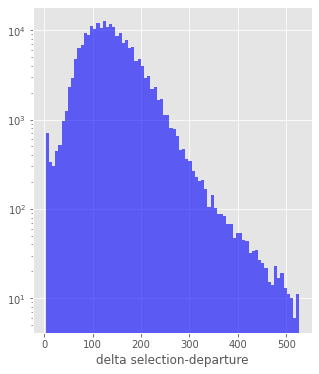

feature: delta departure-presentation, distinct: 1256, min: 10, max: 1269


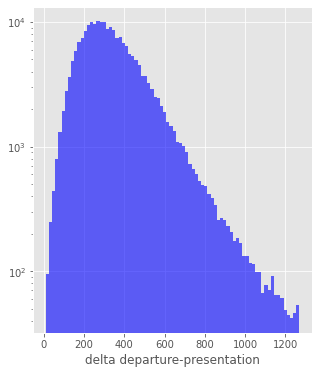

feature: delta selection-presentation, distinct: 1417, min: 23, max: 1738


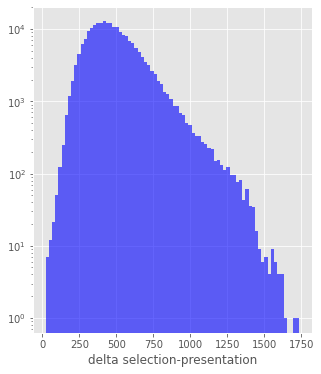

feature: alert reason category, distinct: 9, min: 1, max: 9


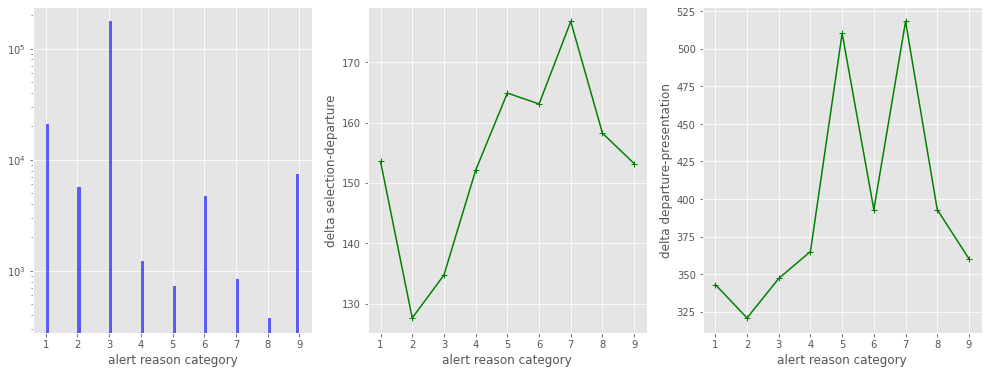

feature: alert_reason_id, distinct: 125, min: 0, max: 124


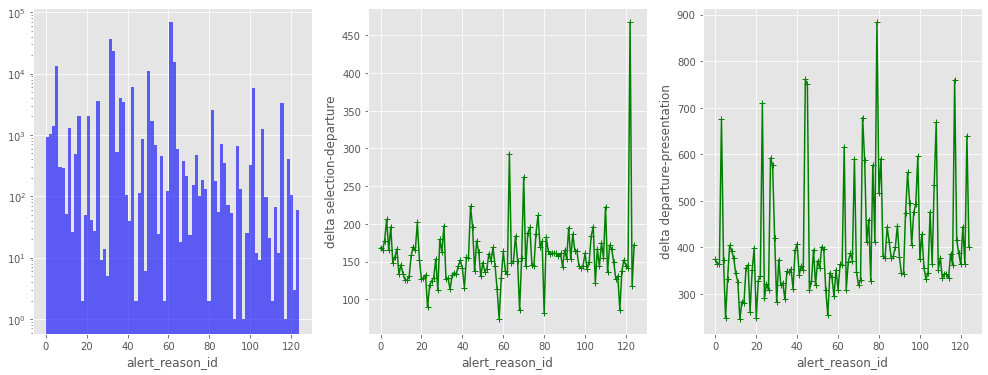

feature: intervention on public roads, distinct: 2, min: 0, max: 1


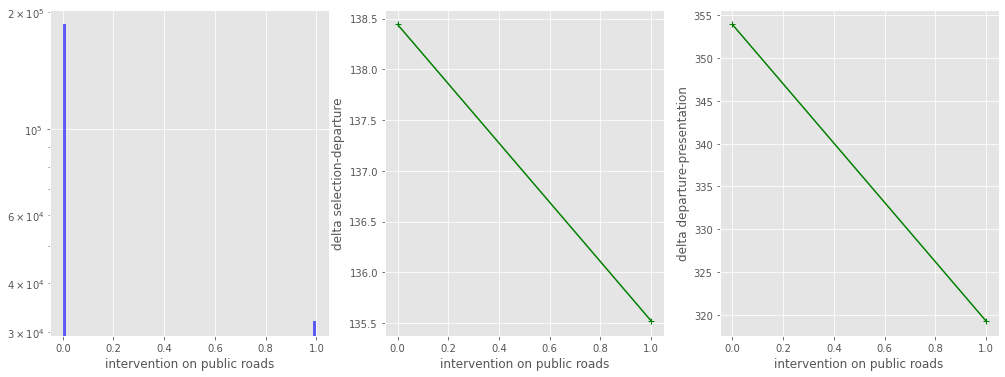

feature: floor, distinct: 45, min: -10, max: 100


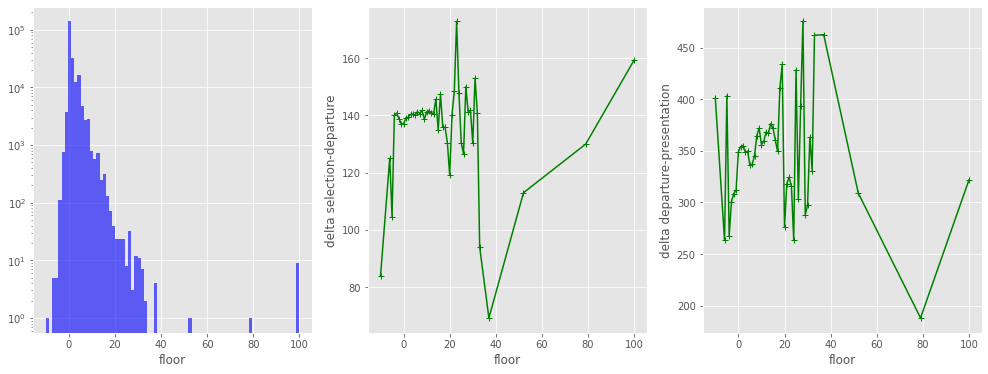

feature: location of the event, distinct: 210, min: 100.0, max: 325.0


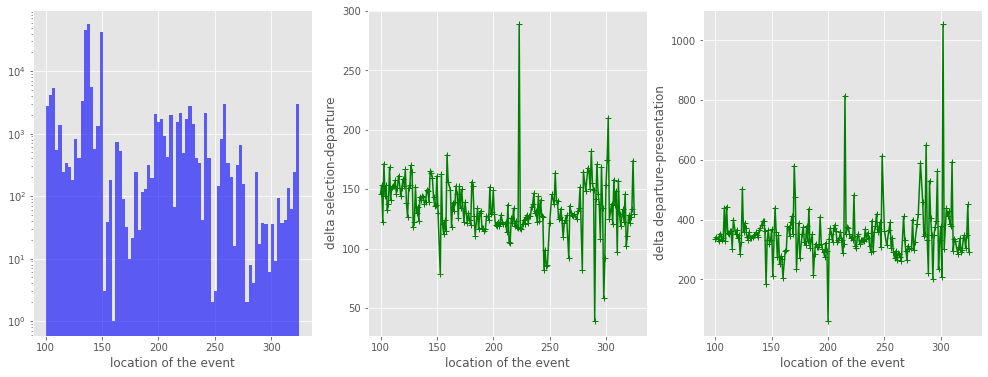

feature: vehicle_type_id, distinct: 51, min: 0, max: 50


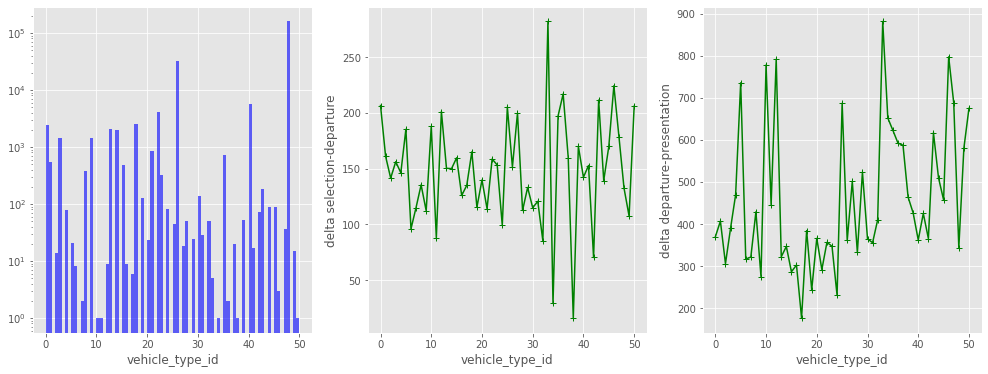

feature: rescue_center_id, distinct: 94, min: 0, max: 93


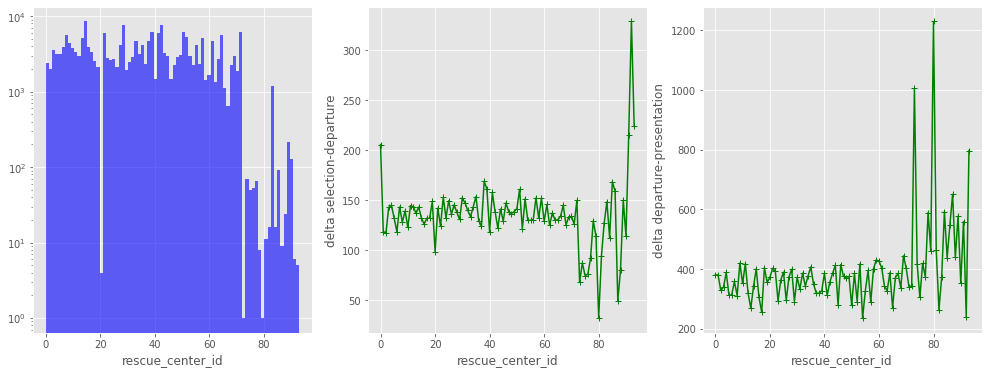

feature: status_preceding_selection_id, distinct: 2, min: 0, max: 1


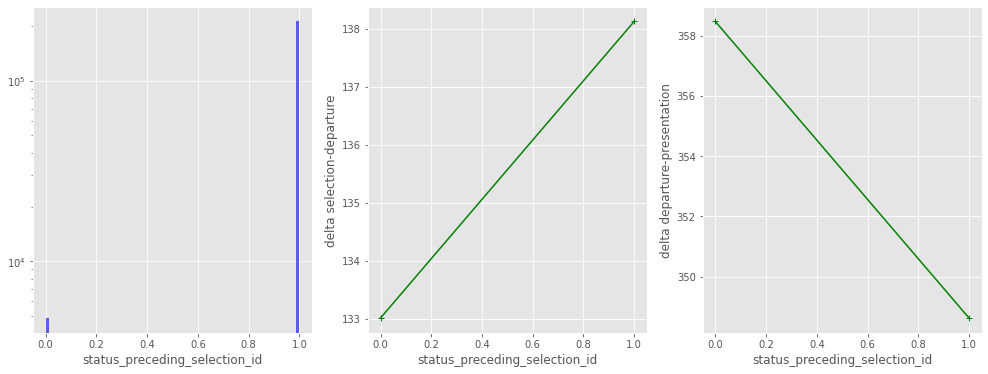

feature: delta status preceding selection-selection, distinct: 49880, min: 0, max: 2587244


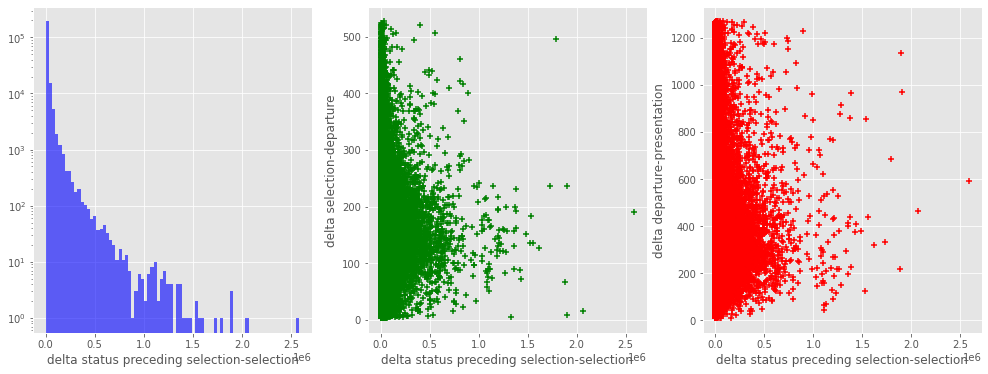

feature: departed from its rescue center, distinct: 2, min: 0, max: 1


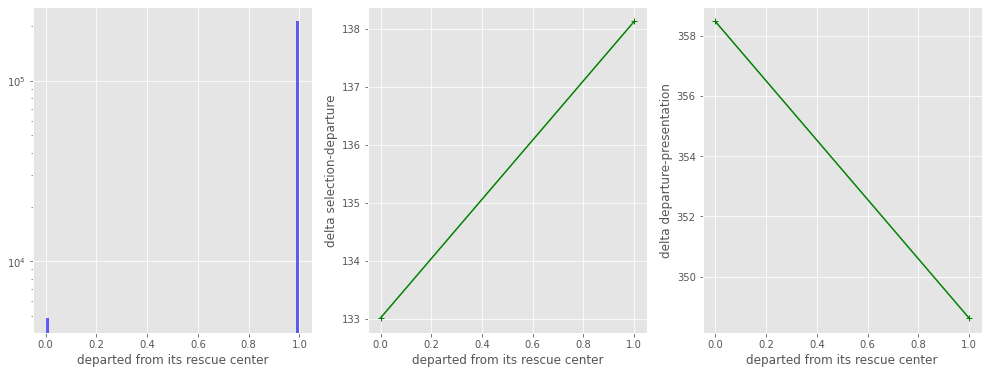

feature: OSRM estimated distance, distinct: 48078, min: 0.8, max: 34468.0


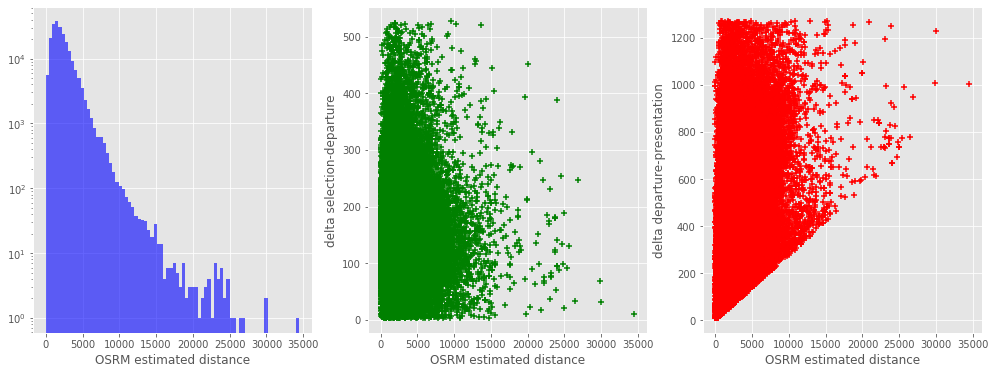

feature: OSRM estimated duration, distinct: 8080, min: 0.1, max: 2025.2


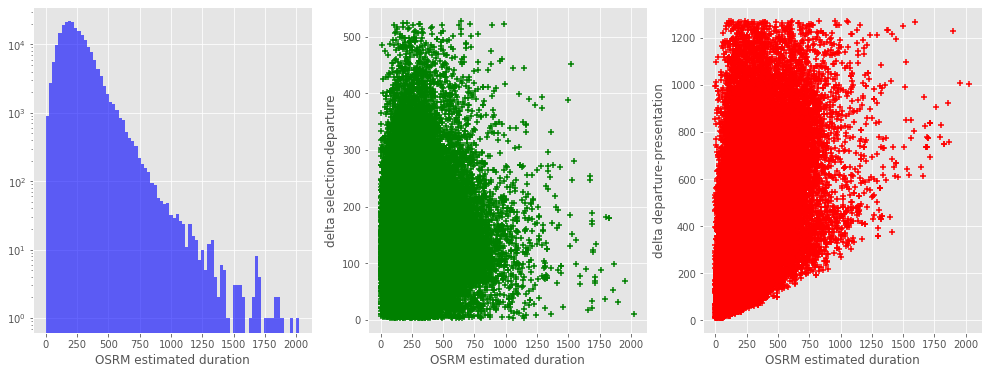

feature: month, distinct: 11, min: 1, max: 12


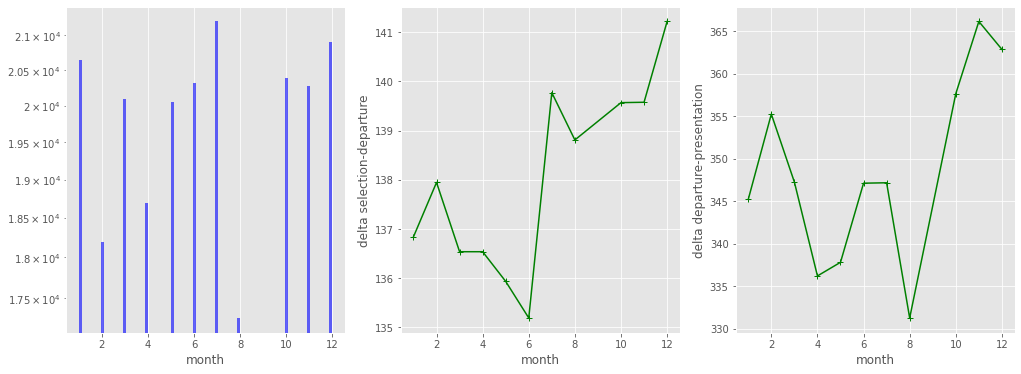

feature: day, distinct: 31, min: 1, max: 31


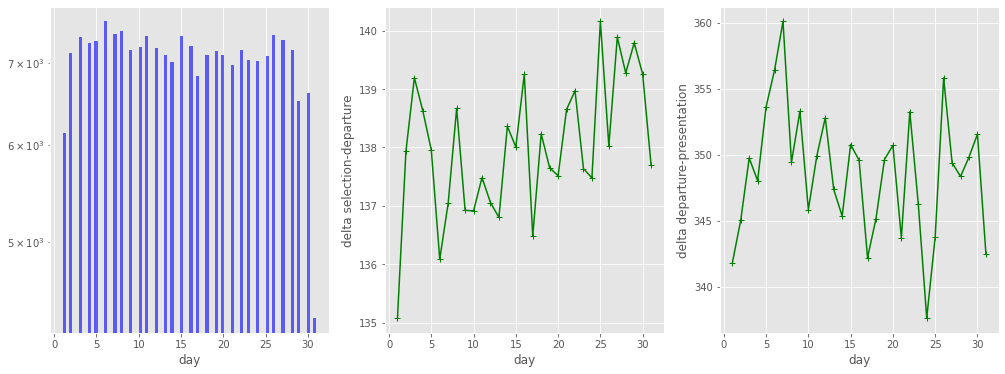

feature: hour, distinct: 24, min: 0, max: 23


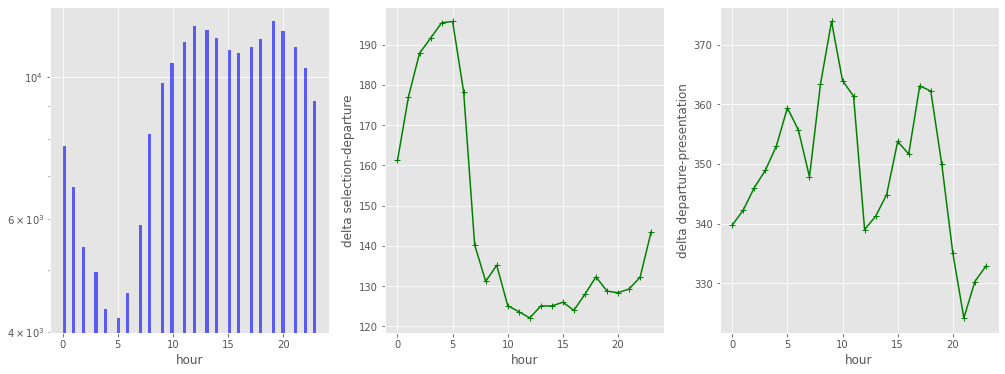

feature: day of week, distinct: 7, min: 0, max: 6


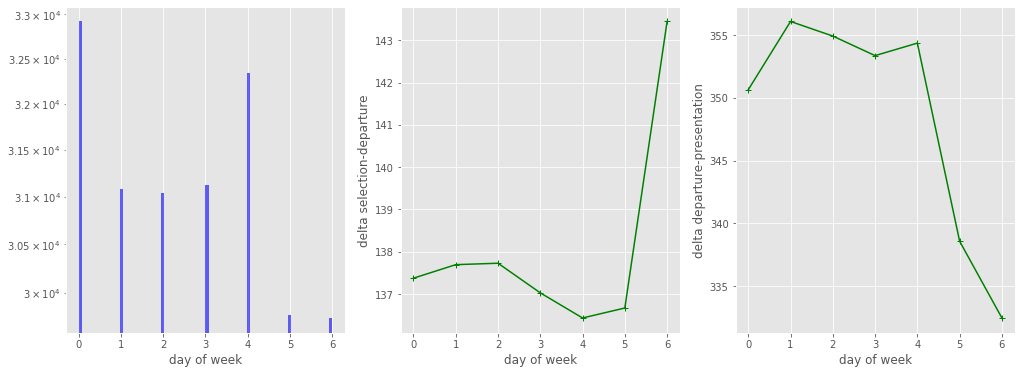

feature: max_temp, distinct: 39, min: -2.0, max: 36.0


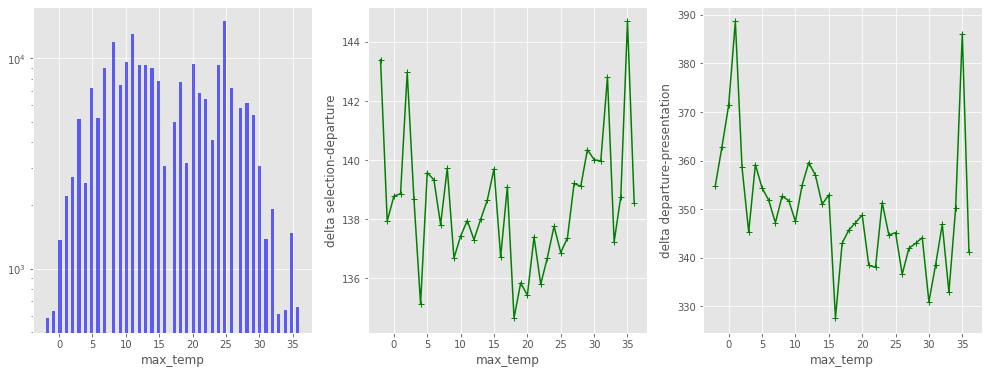

feature: min_temp, distinct: 31, min: -7.0, max: 23.0


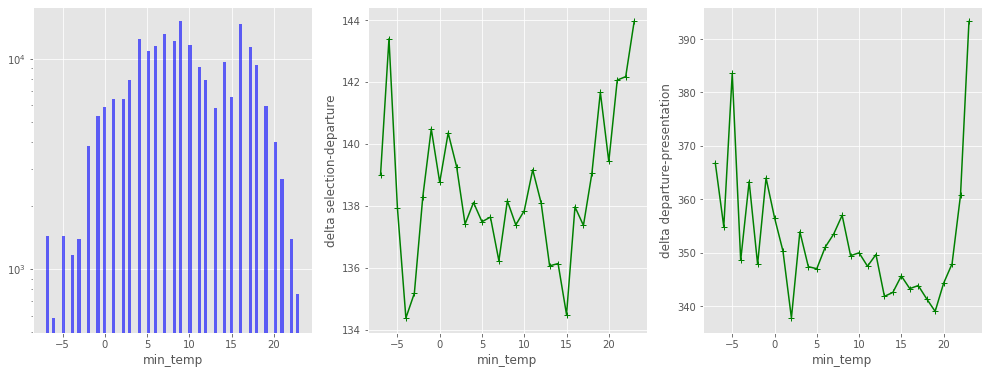

feature: wind_speed, distinct: 32, min: 5.0, max: 39.0


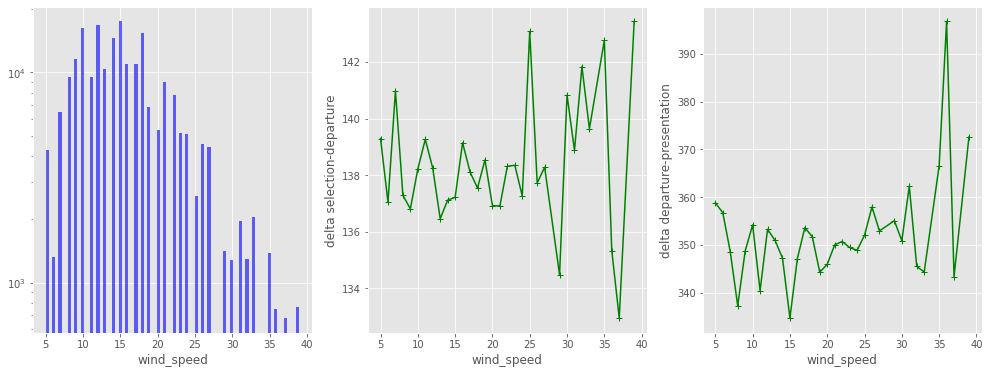

feature: rain_level, distinct: 14, min: 0.0, max: 20.0


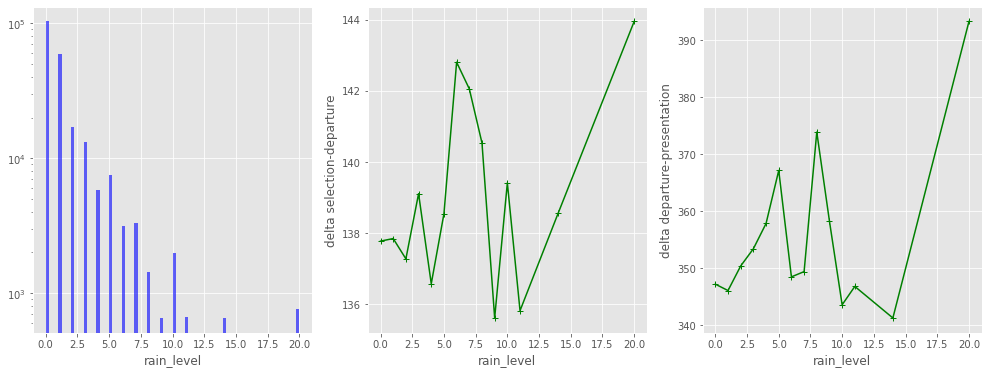

feature: humidity, distinct: 61, min: 32.0, max: 100.0


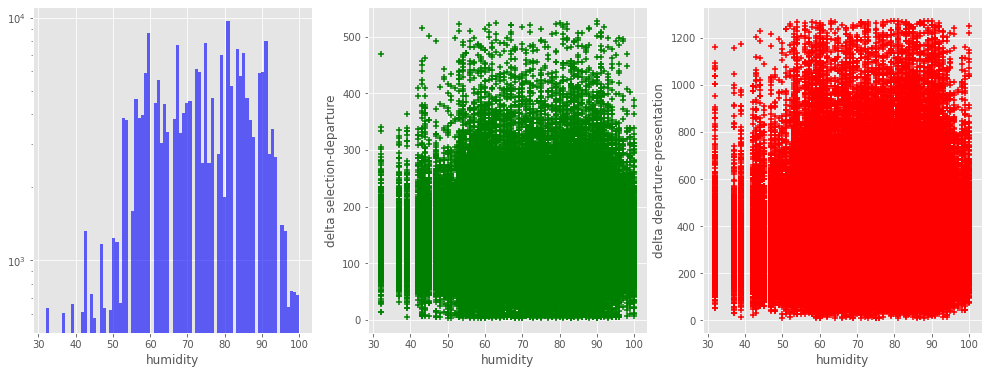

feature: visibility, distinct: 26, min: 3.5, max: 10.0


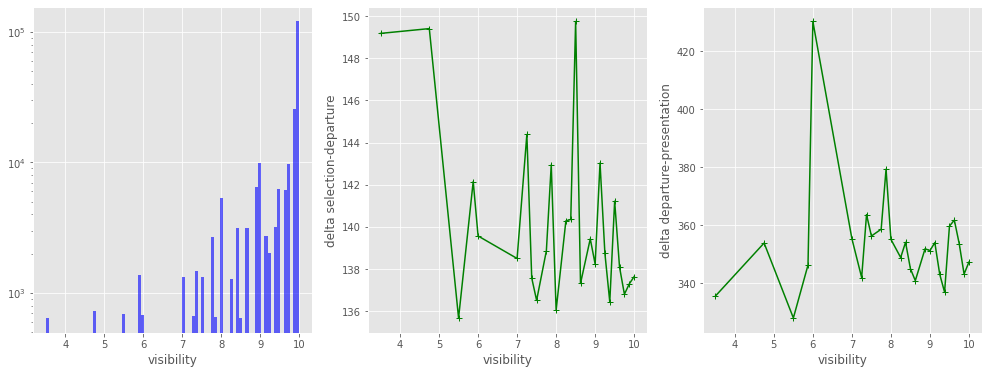

feature: cloud_coverage, distinct: 92, min: 0.0, max: 100.0


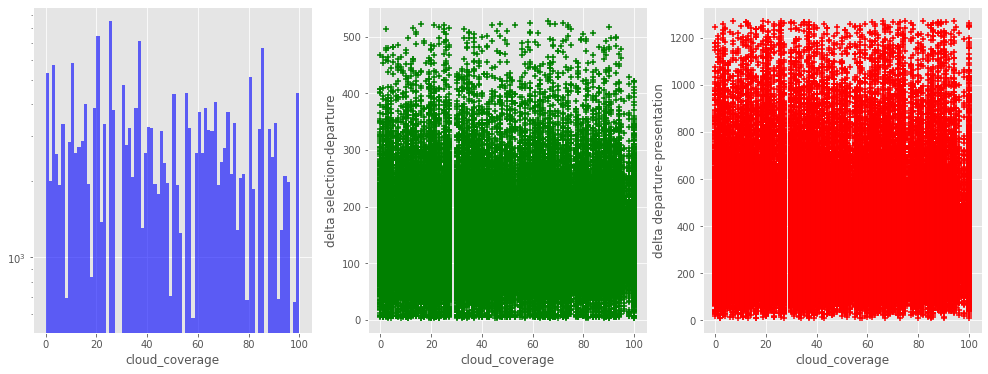

feature: heat_index, distinct: 36, min: 0.0, max: 38.0


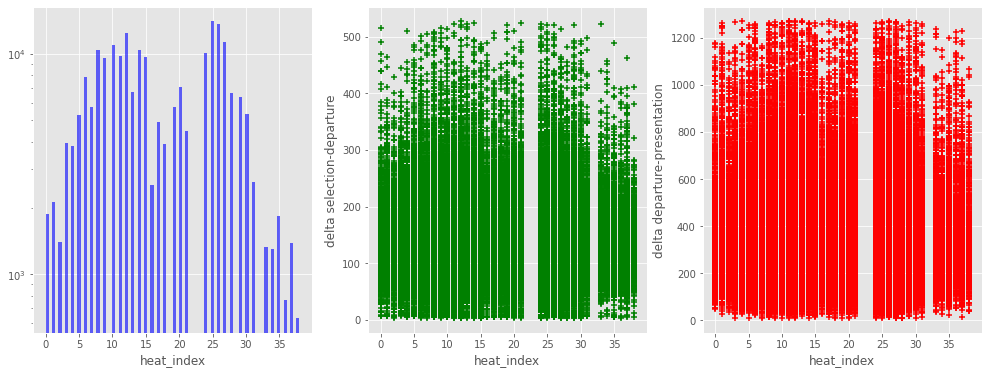

feature: dew_point_temp, distinct: 21, min: 0.0, max: 20.0


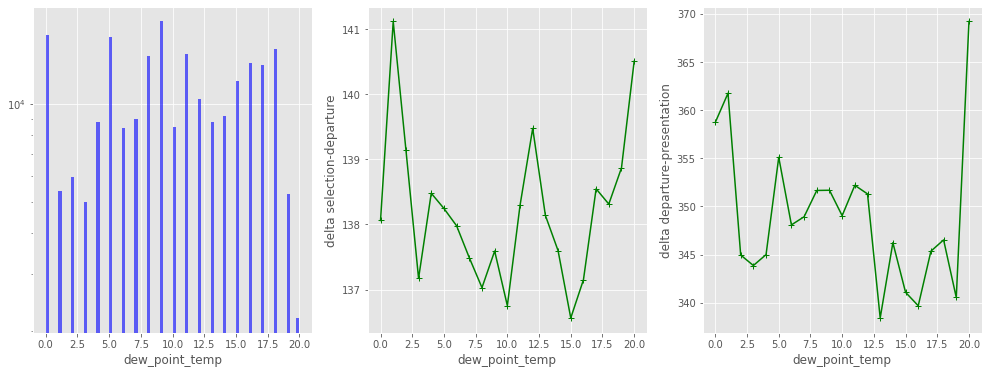

feature: pressure, distinct: 40, min: 992.0, max: 1037.0


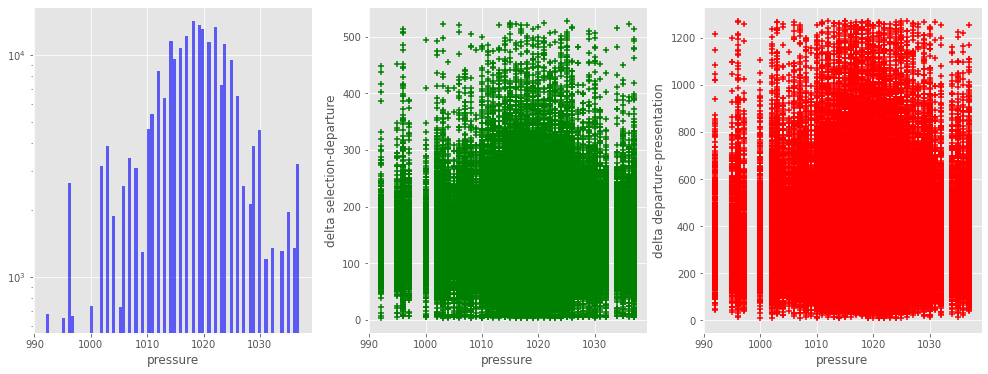

feature: review_id, distinct: 5, min: 0, max: 4


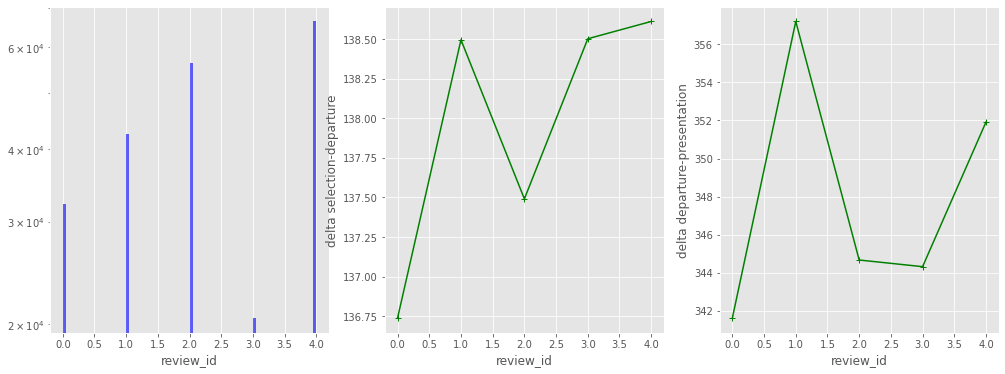

In [15]:
features_to_plot = {
    'delta selection-departure': {'hist': True, 'categorical': None},
    'delta departure-presentation': {'hist': True, 'categorical': None},
    'delta selection-presentation': {'hist': True, 'categorical': None},
    'alert reason category': {'hist': True, 'categorical': True},
    'alert_reason_id': {'hist': True, 'categorical': True},
    'intervention on public roads': {'hist': True, 'categorical': True},
    'floor': {'hist': True, 'categorical': True},
    'location of the event': {'hist': True, 'categorical': True},
    'vehicle_type_id': {'hist': True, 'categorical': True},
    'rescue_center_id': {'hist': True, 'categorical': True},
    'status_preceding_selection_id': {'hist': True, 'categorical': True},
    'delta status preceding selection-selection': {'hist': True, 'categorical': False},
    'departed from its rescue center': {'hist': True, 'categorical': True},
    'OSRM estimated distance': {'hist': True, 'categorical': False},
    'OSRM estimated duration': {'hist': True, 'categorical': False},
    'month': {'hist': True, 'categorical': True},
    'day': {'hist': True, 'categorical': True},
    'hour': {'hist': True, 'categorical': True},
    'day of week': {'hist': True, 'categorical': True},
    'max_temp': {'hist': True, 'categorical': True},
    'min_temp': {'hist': True, 'categorical': True},
    'wind_speed': {'hist': True, 'categorical': True},
    'rain_level': {'hist': True, 'categorical': True},
    'humidity': {'hist': True, 'categorical': False},
    'visibility': {'hist': True, 'categorical': True},
    'cloud_coverage': {'hist': True, 'categorical': False},
    'heat_index': {'hist': True, 'categorical': False},
    'dew_point_temp': {'hist': True, 'categorical': True},
    'pressure': {'hist': True, 'categorical': False},
    'review_id': {'hist': True, 'categorical': True}
}

for col_name in features_to_plot.keys():
    tmp = train.drop(train[train[col_name].isna()].index, inplace=False)
    print('feature: {}, distinct: {}, min: {}, max: {}'.format(col_name,
                                                               len(set(tmp[col_name])),
                                                               min(set(tmp[col_name])),
                                                               max(set(tmp[col_name]))
                                                              ))
    
    plt.figure(figsize=(17, 6))

    plot_hist = features_to_plot[col_name]['hist']
    if plot_hist:
        plt.subplot(131)
        plt.xlabel(col_name)
        # plt.xscale('log')
        plt.yscale('log')
        _, _, _ = plt.hist(tmp[col_name], color='b', bins=80, alpha=.6)

    plot_y = features_to_plot[col_name]['categorical']
    if plot_y is not None:
        y1 = 'delta selection-departure'
        y2 = 'delta departure-presentation'
        # y1 = 'log selection-departure'
        # y2 = 'log departure-presentation'
        if plot_y:
            tmp_plot = tmp.groupby(col_name)
            plt.subplot(132)
            plt.xlabel(col_name)
            plt.ylabel(y1)
            # plt.errorbar(x=list(tmp_plot.mean()[y1].index), y=tmp_plot.mean()[y1], yerr=tmp_plot.std()[y1],
            #              color='green', marker='+', ecolor='black', elinewidth=1, fmt=' ')
            plt.plot(list(tmp_plot.mean()[y1].index), tmp_plot.mean()[y1],
              color='green', marker='+')
            plt.subplot(133)
            plt.xlabel(col_name)
            plt.ylabel(y2)
            # plt.errorbar(x=list(tmp_plot.mean()[y2].index), y=tmp_plot.mean()[y2], yerr=tmp_plot.std()[y2],
            #              color='red', marker='+', ecolor='black', elinewidth=1, fmt=' ')
            plt.plot(list(tmp_plot.mean()[y2].index), tmp_plot.mean()[y2],
              color='green', marker='+')
            
        else:
            plt.subplot(132)
            plt.xlabel(col_name)
            plt.ylabel(y1)
            plt.scatter(tmp[col_name], tmp[y1], color='green', marker='+')
            plt.subplot(133)
            plt.xlabel(col_name)
            plt.ylabel(y2)
            plt.scatter(tmp[col_name], tmp[y2], color='red', marker='+')
    
    plt.show()

# Graph

In [0]:
import networkx as nx

long = train['longitude intervention']
lat = train['latitude intervention']
long_lat_interventions = list(map(lambda x: (x[0], x[1]), np.vstack((long, lat)).T))
nb_intervention_places = len(set(long_lat_interventions))
dict_interventions = dict(zip(set(long_lat_interventions), range(nb_intervention_places)))

long = train['longitude before departure']
lat = train['latitude before departure']
long_lat_vehicles = list(map(lambda x: (x[0], x[1]), np.vstack((long, lat)).T))
nb_vehicle_places = len(set(long_lat_vehicles))
dict_vehicles = dict(zip(set(long_lat_vehicles), nb_intervention_places + np.arange(nb_vehicle_places)))

edges = [(dict_interventions[i], dict_vehicles[v]) for i, v in zip(long_lat_interventions, long_lat_vehicles)]

intervention_graph_train = nx.Graph()
intervention_graph_train.add_nodes_from(range(nb_intervention_places))
pos_interventions = {k: np.array(long_lat_interventions[k]) for k in range(nb_intervention_places)}

vehicle_graph_train = nx.Graph()
vehicle_graph_train.add_nodes_from(range(nb_vehicle_places))
pos_vehicles = {nb_intervention_places+k: np.array(long_lat_vehicles[k]) for k in range(nb_vehicle_places)}

full_graph_train = nx.Graph()
full_graph_train.add_nodes_from(range(nb_intervention_places + nb_vehicle_places))
full_graph_train.add_edges_from(edges)

pos_full = {
    k: pos_interventions[k] if k < nb_intervention_places else pos_vehicles[k] 
    for k in range(nb_intervention_places + nb_vehicle_places)
}

In [0]:
full_graph_train = nx.Graph()
full_graph_train.add_nodes_from(range(nb_intervention_places + nb_vehicle_places))
full_graph_train.add_edges_from(edges)

pos_full = {
    k: pos_interventions[k] if k < nb_intervention_places else pos_vehicles[k] 
    for k in range(nb_intervention_places + nb_vehicle_places)
}

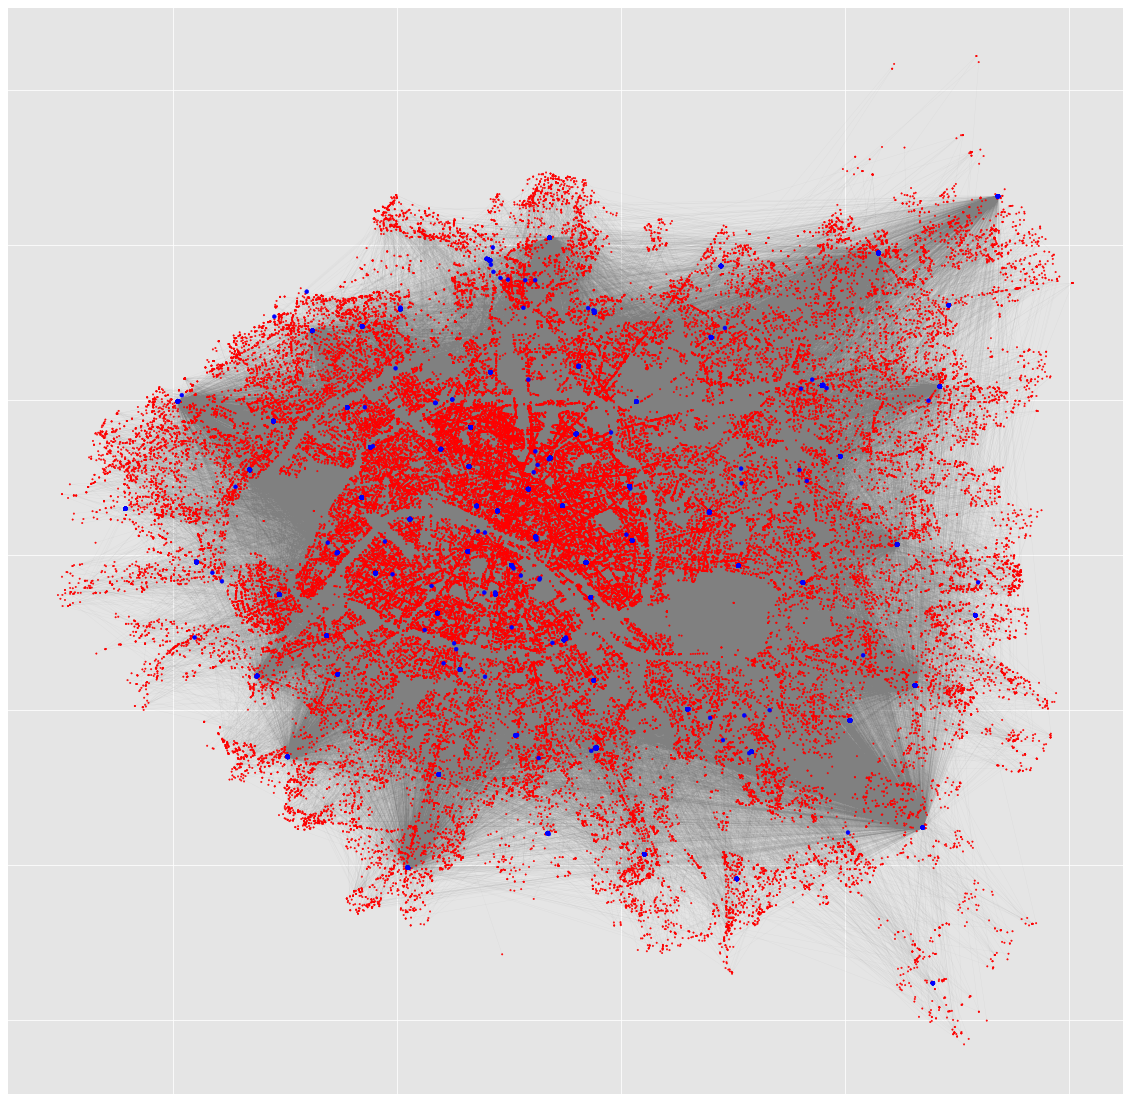

In [18]:
node_colors = ['r' if u < nb_intervention_places else 'b' for u in full_graph_train.nodes()]
node_sizes = [2 if u < nb_intervention_places else 15 for u in full_graph_train.nodes()]

plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(full_graph_train, pos_full, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(full_graph_train, pos_full, alpha=.1, width=.3, edge_color='grey')
plt.show()

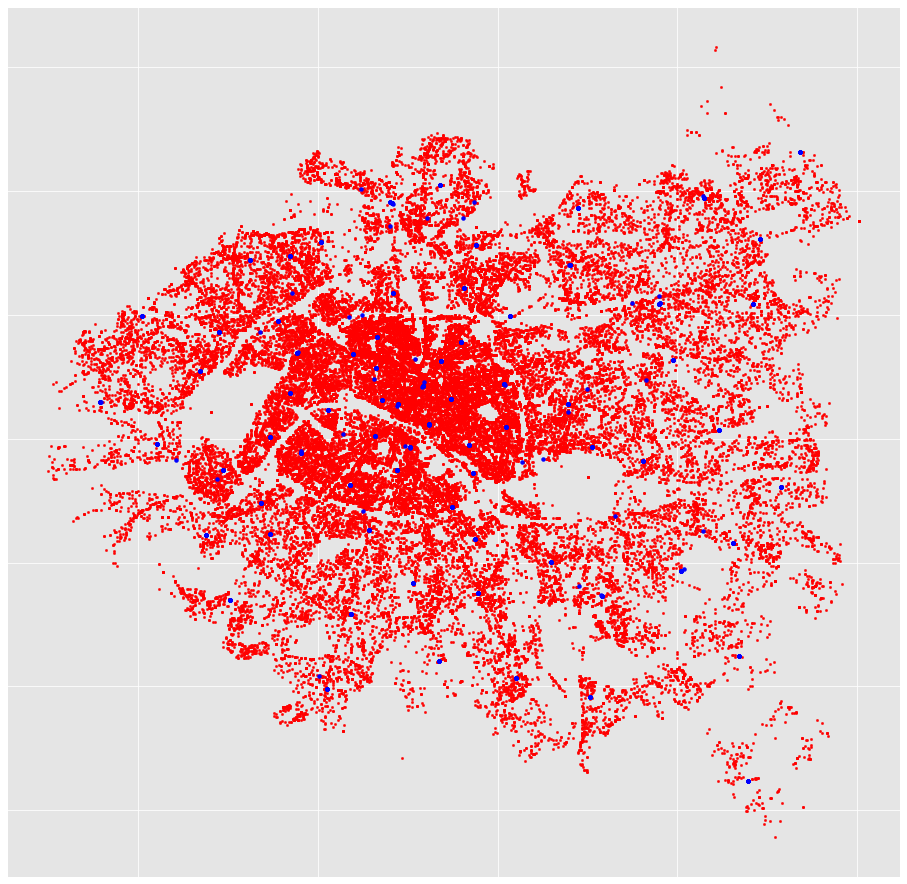

In [19]:
long = test['longitude intervention']
lat = test['latitude intervention']
long_lat = list(map(lambda x: (x[0], x[1]), np.vstack((long, lat)).T))
intervention_graph = nx.Graph()
intervention_graph.add_nodes_from(range(len(set(long_lat))))
pos_interventions = {k: np.array(long_lat[k]) for k in range(len(set(long_lat)))}

long = test['longitude before departure']
lat = test['latitude before departure']
long_lat = list(map(lambda x: (x[0], x[1]), np.vstack((long, lat)).T))
vehicle_graph = nx.Graph()
vehicle_graph.add_nodes_from(range(len(set(long_lat))))
pos_vehicles = {k: np.array(long_lat[k]) for k in range(len(set(long_lat)))}

plt.figure(figsize=(16, 16))
nx.draw_networkx_nodes(intervention_graph, pos_interventions, node_size=5, node_color='r')
nx.draw_networkx_nodes(vehicle_graph, pos_vehicles, node_size=15, node_color='b')
plt.show()

# Training

True True


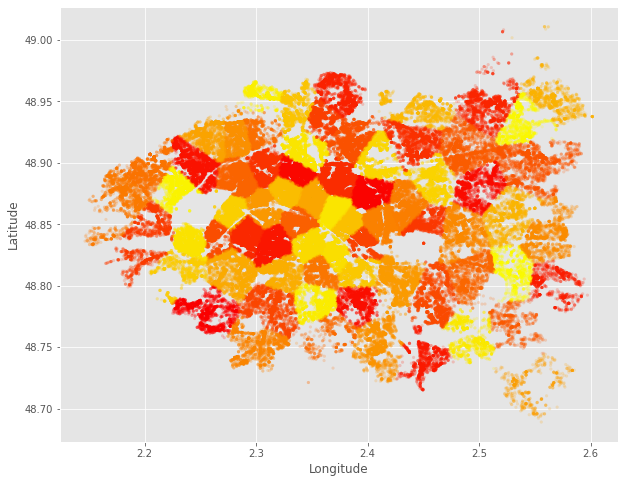

In [20]:
# cluster the longitudes/latitudes into neighborhoods
from sklearn.cluster import MiniBatchKMeans

coords = np.vstack((
    train[['latitude intervention', 'longitude intervention']].values,
    train[['latitude before departure', 'longitude before departure']].values
))

sample_ind = np.random.permutation(len(coords))[:50000]
kmeans = MiniBatchKMeans(n_clusters=70, batch_size=3000).fit(coords[sample_ind])

departure_cluster_train = kmeans.predict(train[['latitude before departure', 'longitude before departure']])
departure_cluster_test = kmeans.predict(test[['latitude before departure', 'longitude before departure']])

intervention_cluster_train = kmeans.predict(train[['latitude intervention', 'longitude intervention']])
intervention_cluster_test = kmeans.predict(test[['latitude intervention', 'longitude intervention']])

# train and test locations can be grouped into different clusters so we make sure the set of clusters is the same
while not (set(departure_cluster_train) == set(departure_cluster_test) and set(intervention_cluster_train) == set(intervention_cluster_test)):
  sample_ind = np.random.permutation(len(coords))[:50000]
  kmeans = MiniBatchKMeans(n_clusters=70, batch_size=3000).fit(coords[sample_ind])

  departure_cluster_train = kmeans.predict(train[['latitude before departure', 'longitude before departure']])
  departure_cluster_test = kmeans.predict(test[['latitude before departure', 'longitude before departure']])

  intervention_cluster_train = kmeans.predict(train[['latitude intervention', 'longitude intervention']])
  intervention_cluster_test = kmeans.predict(test[['latitude intervention', 'longitude intervention']])

print(set(departure_cluster_train) == set(departure_cluster_test), set(intervention_cluster_train) == set(intervention_cluster_test))

fig, ax = plt.subplots(figsize=(10, 8), ncols=1, nrows=1)
ax.scatter(train['longitude intervention'].values, train['latitude intervention'].values, s=10, lw=0,
           c=intervention_cluster_train, cmap='autumn', alpha=0.2)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()



departure_cluster_train = pd.get_dummies(departure_cluster_train, prefix='dep_cluster')
departure_cluster_test = pd.get_dummies(departure_cluster_test, prefix='dep_cluster')

intervention_cluster_train = pd.get_dummies(intervention_cluster_train, prefix='inter_cluster')
intervention_cluster_test = pd.get_dummies(intervention_cluster_test, prefix='inter_cluster')

In [0]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


lat1 = train['latitude before departure']
lng1 = train['longitude before departure']
lat2 = train['latitude intervention']
lng2 = train['longitude intervention']
haversine_dist_train = pd.DataFrame(haversine_array(lat1, lng1, lat2, lng2), columns=['haversine_dist'])
manhattan_dist_train = pd.DataFrame(dummy_manhattan_distance(lat1, lng1, lat2, lng2), columns=['manhattan_dist'])
direction_train = pd.DataFrame(bearing_array(lat1, lng1, lat2, lng2), columns=['direction'])

lat1 = test['latitude before departure']
lng1 = test['longitude before departure']
lat2 = test['latitude intervention']
lng2 = test['longitude intervention']
haversine_dist_test = pd.DataFrame(haversine_array(lat1, lng1, lat2, lng2), columns=['haversine_dist'])
manhattan_dist_test = pd.DataFrame(dummy_manhattan_distance(lat1, lng1, lat2, lng2), columns=['manhattan_dist'])
direction_test = pd.DataFrame(bearing_array(lat1, lng1, lat2, lng2), columns=['direction'])

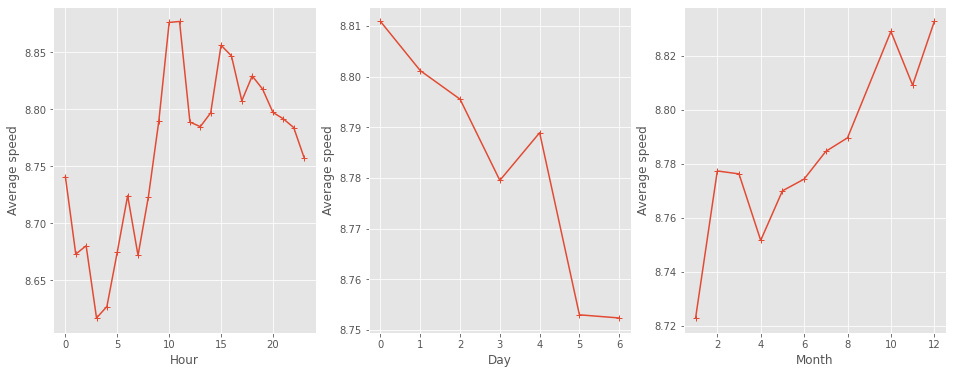

In [22]:
train['avg_speed'] = train['OSRM estimated distance'] / train['OSRM estimated duration']
test['avg_speed'] = test['OSRM estimated distance'] / test['OSRM estimated duration']

plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.xlabel('Hour')
plt.ylabel('Average speed')
plt.plot(train.groupby('hour').mean()['avg_speed'], marker='+')
plt.subplot(132)
plt.xlabel('Day')
plt.ylabel('Average speed')
plt.plot(train.groupby('day of week').mean()['avg_speed'], marker='+')
plt.subplot(133)
plt.xlabel('Month')
plt.ylabel('Average speed')
plt.plot(train.groupby('month').mean()['avg_speed'], marker='+')
plt.show()

In [23]:
# one-hot encoding
alert_cat_train = pd.get_dummies(train['alert reason category'], prefix='acat')
alert_cat_test = pd.get_dummies(test['alert reason category'], prefix='acat')

inter_public_train = pd.get_dummies(train['intervention on public roads'], prefix='intp')
inter_public_test = pd.get_dummies(test['intervention on public roads'], prefix='intp')

floor_train = np.maximum(np.minimum(train['floor'], 19), -3)
floor_test = np.maximum(np.minimum(test['floor'], 19), -3)

vehicle_cat_train = train['emergency vehicle type']
vehicle_cat_test = test['emergency vehicle type']
vehicle_cat_test[vehicle_cat_test == 'VES'] = 'VSAV'

vehicle_cat = pd.DataFrame(pd.concat([
    vehicle_cat_train,
    vehicle_cat_test
], axis=0), columns=['vehicle_type'])
tmp = pd.get_dummies(vehicle_cat, prefix='vtype')

vehicle_cat_train = tmp[:len(vehicle_cat_train)]
vehicle_cat_test = tmp[len(vehicle_cat_train):]

status_sel_train = pd.get_dummies(train['status preceding selection'], prefix='sps')
status_sel_test = pd.get_dummies(test['status preceding selection'], prefix='sps')

departed_train = pd.get_dummies(train['departed from its rescue center'], prefix='drc')
departed_test = pd.get_dummies(test['departed from its rescue center'], prefix='drc')

month_train = pd.get_dummies(train['month'], prefix='month')
month_test = pd.get_dummies(test['month'], prefix='month')

day_train = pd.get_dummies(train['day'], prefix='day')
day_test = pd.get_dummies(test['day'], prefix='day')

hour_train = pd.get_dummies(train['hour'], prefix='hour')
hour_test = pd.get_dummies(test['hour'], prefix='hour')

weekday_train = pd.get_dummies(train['day of week'], prefix='dayweek')
weekday_test = pd.get_dummies(test['day of week'], prefix='dayweek')

review_train = pd.get_dummies(train['review'], prefix='review')
review_test = pd.get_dummies(test['review'], prefix='review')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [24]:
from sklearn.model_selection import KFold, GridSearchCV, cross_validate
from sklearn.metrics import r2_score
import xgboost as xgb

# create the dataset
other_features = [
    'longitude intervention',
    'latitude intervention',
#     'delta status preceding selection-selection'
    'longitude before departure',
    'latitude before departure',
    'OSRM estimated distance',
#     'OSRM estimated duration',
    'avg_speed',
    'wind_speed',
    'rain_level',
    'visibility',
    'updated OSRM duration',
    'updated OSRM',
    'GPS estimation',
    'GPS available',
    'GPS and updated OSRM'
]

dataset = pd.concat([
    train[other_features].reset_index(),
    departure_cluster_train.reset_index(),
    intervention_cluster_train.reset_index(),
    haversine_dist_train.reset_index(),
    manhattan_dist_train.reset_index(),
    direction_train.reset_index(),
    alert_cat_train.reset_index(),
    inter_public_train.reset_index(),
    floor_train.reset_index(),
    vehicle_cat_train.reset_index(),
    status_sel_train.reset_index(),
    departed_train.reset_index(),
    month_train.reset_index(),
#    day_train,
    hour_train.reset_index(),
    weekday_train.reset_index(),
#     review_train.reset_index()
], axis=1)
dataset.drop('index', axis=1, inplace=True)

test_set = pd.concat([
    test[other_features].reset_index(),
    departure_cluster_test.reset_index(),
    intervention_cluster_test.reset_index(),
    haversine_dist_test.reset_index(),
    manhattan_dist_test.reset_index(),
    direction_test.reset_index(),
    alert_cat_test.reset_index(),
    inter_public_test.reset_index(),
    floor_test.reset_index(),
    vehicle_cat_test.reset_index(),
    status_sel_test.reset_index(),
    departed_test.reset_index(),
    month_test.reset_index(),
#    day_test,
    hour_test.reset_index(),
    weekday_test.reset_index(),
#     review_test.reset_index()
], axis=1)
test_set.drop('index', axis=1, inplace=True)

print(dataset.shape, test_set.shape)

labels1 = train['delta selection-departure']
labels2 = train['delta departure-presentation']
#labels1 = np.log(labels1)
labels2 = np.log(labels2)

(218022, 215) (108033, 215)


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# change to try other parameters
SEED = 42
for mcw in [3, 5, 7, 10, 15]:
    tmp_model = xgb.XGBRegressor(
        min_children_weight=mcw,
        learning_rate=.09,
        n_estimators=200,
        objective='reg:squarederror',
        gamma=5,
        reg_lambda=1,
        reg_alpha=2,
        colsample_bytree=.9,
        subsample=.8,
        max_depth=8,
        sampling_method='uniform',
        tree_method='gpu_hist',
        gpu_id=0,
        seed=SEED
    )

    cv_scores1 = cross_validate(tmp_model, dataset, labels1, cv=3, scoring='r2', return_train_score=True)
    cv_scores2 = cross_validate(tmp_model, dataset, labels2, cv=3, scoring='r2', return_train_score=True)

    print('Seed: {}'.format(SEED))
    print('Test 1: {}, train 1: {}'.format(cv_scores1['test_score'].mean(), cv_scores1['train_score'].mean()))
    print('Test 2: {}, train 2: {}'.format(cv_scores2['test_score'].mean(), cv_scores2['train_score'].mean()))

# updated OSRM duration:                               test 0.248/0.516  train 0.404/0.605
# updated OSRM duration + updated OSRM:                test 0.257/0.526  train 0.412/0.612
# GPS estimation:                                      test 0.235/0.532  train 0.390/0.616
# GPS estimation + GPS available:                      test 0.240/0.538  train 0.395/0.622
# GPS and updated OSRM:                                test 0.238/0.524  train 0.391/0.610
# GPS and updated OSRM + update OSRM + GPS available:  test 0.244/0.545  train 0.399/0.629
######
# all except OSRM estimated duration:                  test 0.294/0.548  train 0.447/0.634
######
# all:                                                 test 0.294/0.548  train 0.447/0.634

# new long/lat:                                        test 0.296/0.548  train 0.448/0.636
# new long/lat/distances/direction:                    test 0.300/0.544  train 0.450/0.632

# - longitudes - latitudes:                            test 0.240/0.541  train 0.380/0.619
# - avg_speed with OSRM estimated duration:            test 0.245/0.544  train 0.394/0.626
# - wind_speed:                                        test 0.243/0.544  train 0.395/0.626
# - rain_level:                                        test 0.243/0.545  train 0.396/0.629

# best with ~log1/log2:                                test 0.294/0.548  train 0.447/0.634
# best with log1/log2:                                 test 0.236/0.548  train 0.379/0.634
# best with ~log1/~log2:                               test 0.294/0.539  train 0.447/0.648

Seed: 42
Test 1: 0.2956517264863217, train 1: 0.4362131176686441
Test 2: 0.5474518968346064, train 2: 0.6190404606411098


In [0]:
tmp_model = xgb.XGBRegressor(
    min_children_weight=10,
    learning_rate=.09,
    n_estimators=200,
    objective='reg:squarederror',
    gamma=5,
    reg_lambda=1,
    reg_alpha=2,
    colsample_bytree=.9,
    subsample=.8,
    max_depth=8,
    sampling_method='uniform',
    tree_method='gpu_hist',
    gpu_id=0,
    seed=SEED
)

tmp_model.fit(dataset, labels1)
y_pred1 = pd.DataFrame(tmp_model.predict(test_set))

tmp_model = xgb.XGBRegressor(
    min_children_weight=10,
    learning_rate=.1,
    n_estimators=200,
    objective='reg:squarederror',
    gamma=5,
    reg_lambda=1,
    reg_alpha=2,
    colsample_bytree=.9,
    subsample=.8,
    max_depth=8,
    sampling_method='uniform',
    tree_method='gpu_hist',
    gpu_id=0,
    seed=SEED
)

tmp_model.fit(dataset, labels2)
y_pred2 = pd.DataFrame(np.exp(tmp_model.predict(test_set)))

y_pred3 = y_pred1 + y_pred2

# create submission
submission = pd.concat([
    test['emergency vehicle selection'],
    pd.DataFrame(np.round(y_pred1)),
    pd.DataFrame(np.round(y_pred2)),
    pd.DataFrame(np.round(y_pred3))
], axis=1)

submission.columns = list(y_train.columns.values)
submission.set_index('emergency vehicle selection', inplace=True)
submission.to_csv(path + 'submission.csv', sep=",")

In [0]:
# cross-validation then submit
params = {
    'min_children_weight': [5, 10, 20],
    'eta': [.1, .3],
    'colsample_bytree': [.9],
    'max_depth': [6, 7, 10],
    'gamma': [1, 3, 5],
    'n_estimators': [100, 200],
    'subsample': [.8],
    'sampling_method': ['uniform'],
    'lambda': [1.],
    'nthread': [-1],
    'booster': ['gbtree'],
    'silent': [1],
    'objective': ['reg:squarederror']
}

model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)
clf1 = GridSearchCV(model, params, cv=KFold(n_splits=3), scoring='r2', refit=True)
clf1.fit(dataset, labels1)

best_parameters1, best_score1, model1 = clf1.best_params_, clf1.best_score_, clf1.best_estimator_

print('R2 score: {}\n'.format(best_score1))
for param_name in sorted(best_parameters1.keys()):
    print("%s: %r" % (param_name, best_parameters1[param_name]))

# model1.fit(dataset, labels1)
y_pred1 = pd.DataFrame(model1.predict(test_set))
y_pred1.to_csv(path + 'y1.csv', sep=',')
print('First time predicted')

model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)
clf2 = GridSearchCV(model, params, cv=KFold(n_splits=3), scoring='r2', refit=True)
clf2.fit(dataset, labels2)

best_parameters2, best_score2, model2 = clf2.best_params_, clf2.best_score_, clf2.best_estimator_

print('R2 score: {}\n'.format(best_score2))
for param_name in sorted(best_parameters2.keys()):
    print("%s: %r" % (param_name, best_parameters2[param_name]))

# model2.fit(dataset, labels2)
y_pred2 = pd.DataFrame(np.exp(model2.predict(test_set)))
y_pred2.to_csv(path + 'y2.csv', sep=',')

y_pred3 = y_pred1 + y_pred2

# create submission
submission = pd.concat([
    test['emergency vehicle selection'],
    pd.DataFrame(np.round(y_pred1)),
    pd.DataFrame(np.round(y_pred2)),
    pd.DataFrame(np.round(y_pred3))
], axis=1)

submission.columns = list(y_train.columns.values)
submission.set_index('emergency vehicle selection', inplace=True)
submission.to_csv(path + 'submission.csv', sep=",")

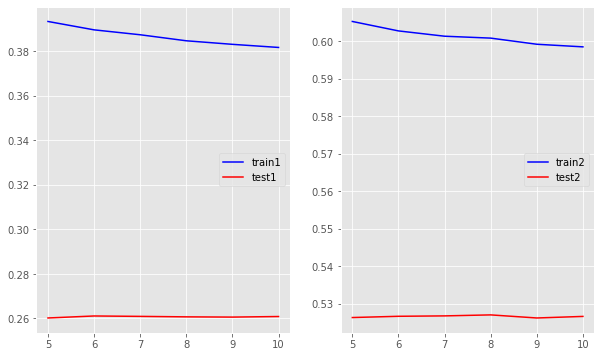

In [0]:
# plot train/test scores

# mcw_values = [1, 2, 5, 10, 20]
# learning_rates = [.01, .05, .1, .2]
# md_val = [6, 7, 8, 10, 12]
# gammas = [.1, .2, 1, 2, 5, 100]
alphas = [10, 100]
lambdas = [5, 6, 7, 8, 9, 10]

train_scores1 = []
test_scores1 = []
train_scores2 = []
test_scores2 = []

params_tuned = lambdas

for p in params_tuned:
    tmp_model = xgb.XGBRegressor(
        min_children_weight=10,
        learning_rate=.1,
        n_estimators=200,
        objective='reg:squarederror', 
        gamma=1,
        reg_lambda=p,
        reg_alpha=1,
        colsample_bytree=.9, 
        subsample=.8,
        max_depth=8,
        sampling_method='uniform',
        tree_method='gpu_hist',
        gpu_id=0
    )

    cv_scores1 = cross_validate(tmp_model, dataset, labels1, cv=3, scoring='r2', return_train_score=True)
    cv_scores2 = cross_validate(tmp_model, dataset, labels2, cv=3, scoring='r2', return_train_score=True)

    train_scores1.append(cv_scores1['train_score'].mean())
    test_scores1.append(cv_scores1['test_score'].mean())

    train_scores2.append(cv_scores2['train_score'].mean())
    test_scores2.append(cv_scores2['test_score'].mean())

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(params_tuned, train_scores1, 'b', label='train1')
plt.plot(params_tuned, test_scores1, 'r', label='test1')
plt.legend()
plt.subplot(122)
plt.plot(params_tuned, train_scores2, 'b', label='train2')
plt.plot(params_tuned, test_scores2, 'r', label='test2')
plt.legend()
plt.show()

In [0]:
print(test_scores1)
print(test_scores2)

[0.26088771643377984, 0.26116638772309714, 0.261113620676377, 0.2611624482270059, 0.26114602531101844]
[0.5266308114198079, 0.5262857831597387, 0.5261825206161268, 0.526095205213074, 0.5260379456157164]


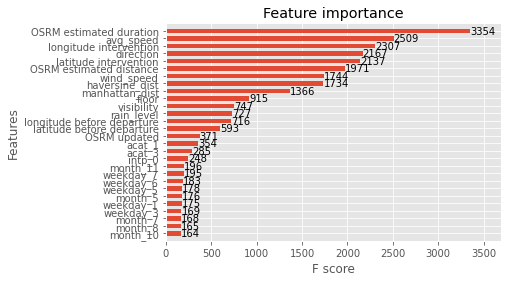

In [0]:
xgb.plot_importance(tmp_model, max_num_features=28, height=.6)